In [64]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches
import seaborn as sns
sns.set_theme()
import pandas as pd
import mne
from scipy.fftpack import fft
from numpy.fft import rfft, irfft, rfftfreq
from sklearn.cross_decomposition import CCA

In [173]:
sub_dirs = ['8hz_20trials/','9hz_20trials/','10hz_20trials/',
            '11hz_10trials_run1/','11hz_10trials_run2/',
            '12hz_10trials_run1/','12hz_10trials_run2/',
            '12.6hz_10trials_run1/','12.6hz_10trials_run2/',
            '13hz_10trials_run1/','13hz_10trials_run2/',
            '14hz_10trials_run1/','14hz_10trials_run2/',
            '15hz_10trials_run1/','15hz_10trials_run2/']

def load_data_temp_function(eeg, meta, classes):
    trials = meta[1:,:2]
    times = meta[:,2]
    times = (times - times[0])[1:]
    eeg['time'] = eeg['time'] - eeg['time'].iloc[0]
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[:1725].T for t in times])[:,:,225:]
    eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
    # eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir',phase='minimum')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg


### PSD Plots

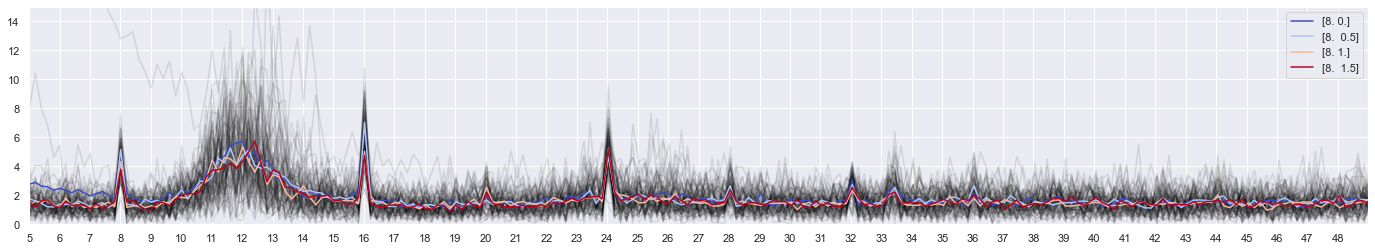

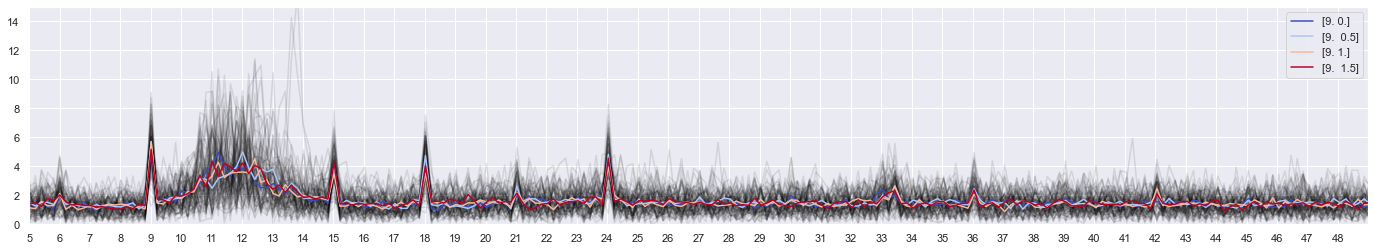

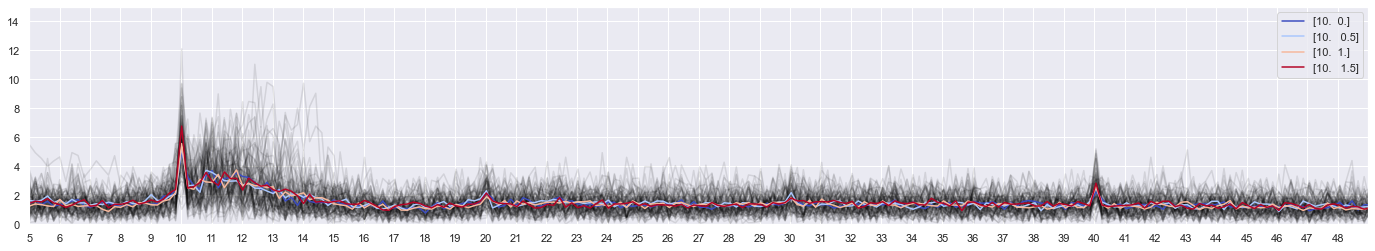

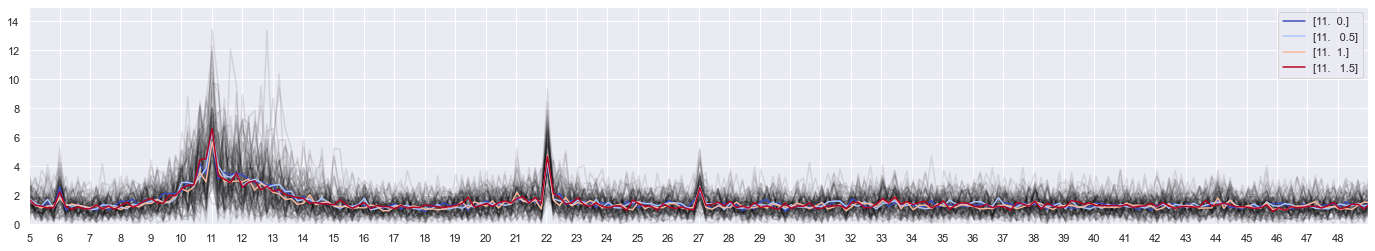

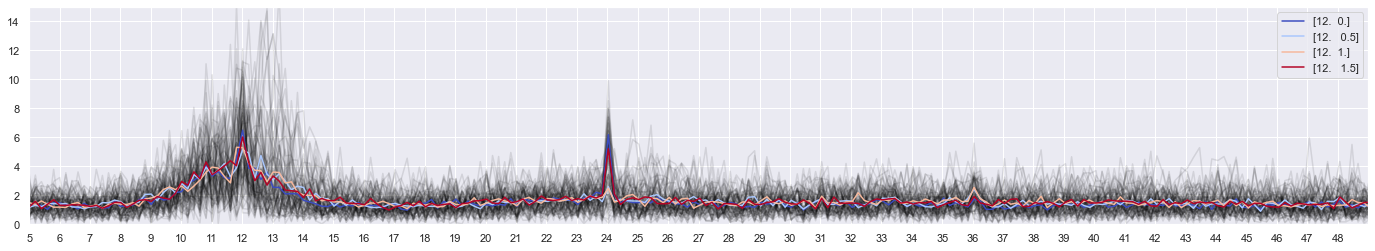

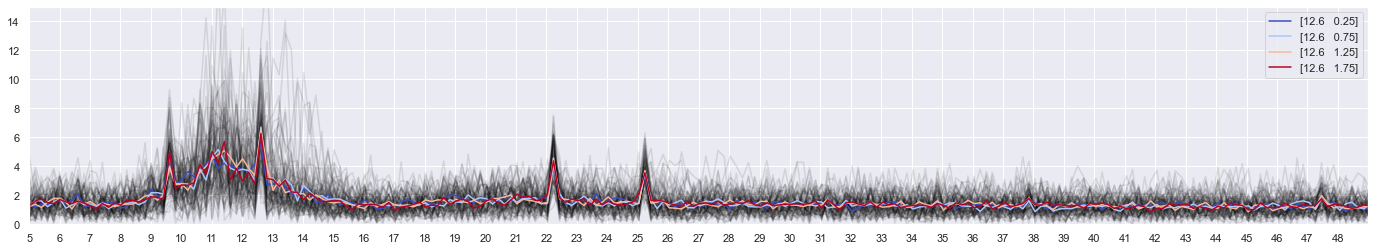

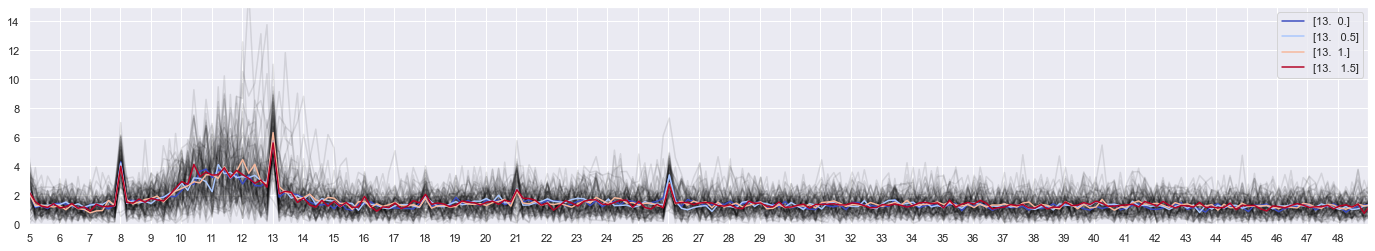

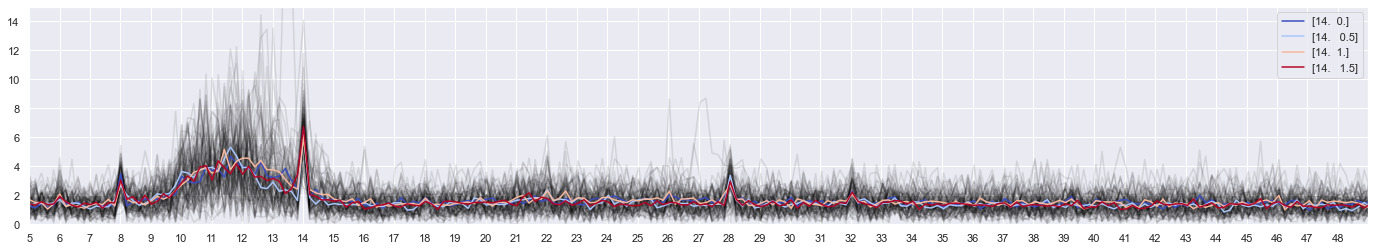

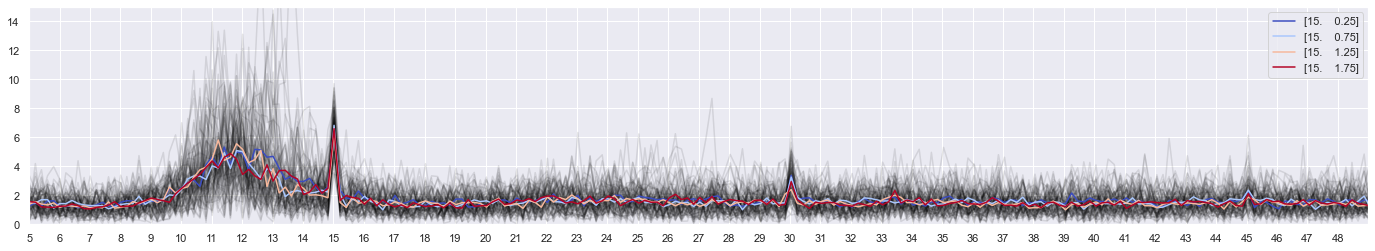

In [169]:
for i_dir,sub_dir in enumerate(sub_dirs):
    if sub_dir[-2] == '2':
        continue
    data_path = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)
    eeg = load_data_temp_function(eeg, meta, classes)
    if sub_dir not in ['8hz_20trials/','9hz_20trials/','10hz_20trials/']:
        if sub_dir[-2] == '1' and i_dir+1 < len(sub_dirs):
            sub_dir2 = sub_dirs[i_dir+1]
            data_path2 = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir2
            eeg2 = pd.read_csv(data_path2 + 'eeg.csv').astype(float)
            meta2 = np.loadtxt(data_path2 + 'meta.csv', delimiter=',', dtype=float)
            trials2 = meta2[1:,:2]
            eeg2 = load_data_temp_function(eeg2,meta2,classes)
            eeg = np.vstack((eeg,eeg2))
    freqs = np.linspace(0.0, 300 / 2, 750)
    psd = 2/750*np.abs(fft(eeg)[:,:,:,:750])
    plt.figure(figsize=(24, 4))
    ax = plt.subplot()
    ax.set_xlim(5, 49)
    ax.set_ylim(0, 15)
    colors=cm.coolwarm(np.linspace(0,1,len(classes)))
    for i,c in enumerate(colors):
        for j in range(eeg.shape[0]):
            sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    for i,c in enumerate(colors):
        sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(classes[i]),color=c)
    plt.xticks(range(5,49));

### Complex Spectra

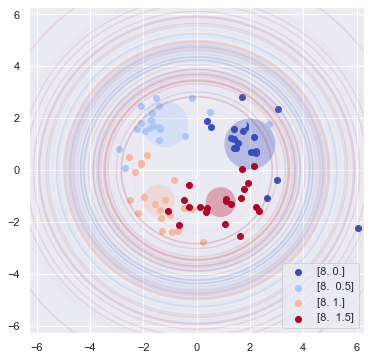

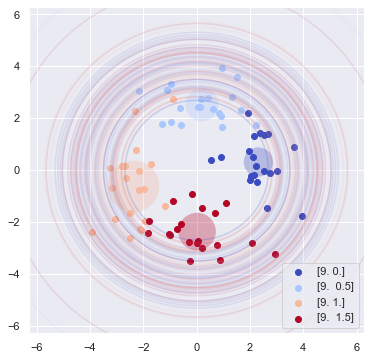

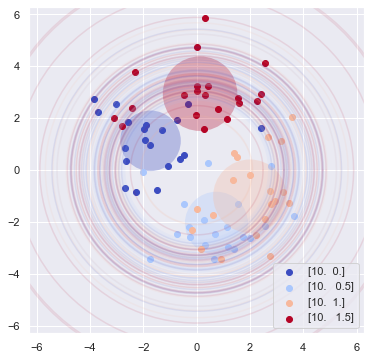

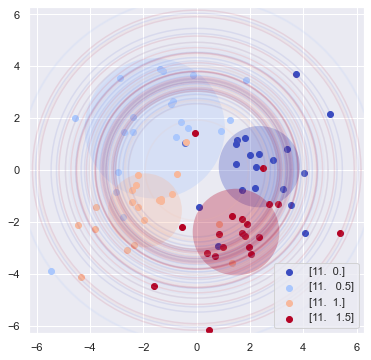

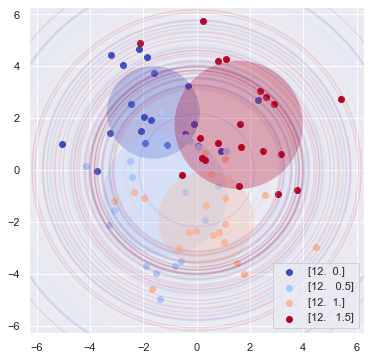

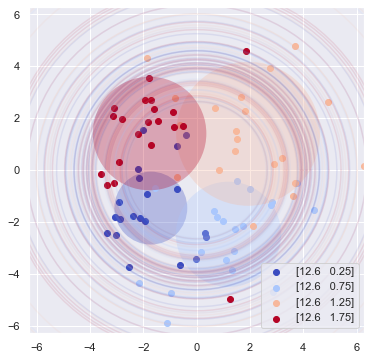

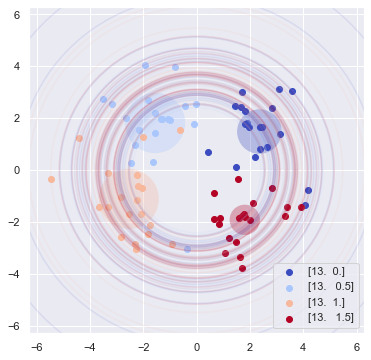

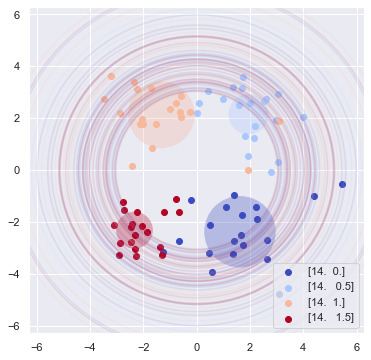

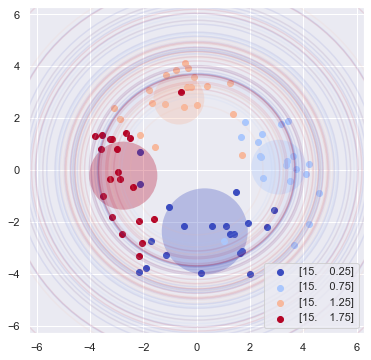

In [208]:
visual_delay = 0.0
visual_delay_samples = int(visual_delay * 300)
for i_dir,sub_dir in enumerate(sub_dirs):
    if sub_dir[-2] == '2':
        continue
    data_path = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)
    eeg = load_data_temp_function(eeg, meta, classes)
    if sub_dir not in ['8hz_20trials/','9hz_20trials/','10hz_20trials/']:
        if sub_dir[-2] == '1' and i_dir+1 < len(sub_dirs):
            sub_dir2 = sub_dirs[i_dir+1]
            data_path2 = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir2
            eeg2 = pd.read_csv(data_path2 + 'eeg.csv').astype(float)
            meta2 = np.loadtxt(data_path2 + 'meta.csv', delimiter=',', dtype=float)
            trials2 = meta2[1:,:2]
            eeg2 = load_data_temp_function(eeg2,meta2,classes)
            eeg = np.vstack((eeg,eeg2))
    freqs = np.linspace(0.0, 300 / 2, (1500-visual_delay_samples)//2)
    complex_spectrum = 1/750*fft(eeg[:,:,:,visual_delay_samples:])[:,:,:,:(1500-visual_delay_samples)//2]
    plt.figure(figsize=(6, 6))
    plt.xlim(-2*np.pi, 2*np.pi)
    plt.ylim(-2*np.pi, 2*np.pi)
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,len(classes)))
    for i,c in enumerate(colors):
        for j in range(complex_spectrum.shape[0]):
            max_radius = np.abs(complex_spectrum[j,i,0,:]).max()
            plt.plot(max_radius*np.cos(np.linspace(0, 2*np.pi, 100)),max_radius*np.sin(np.linspace(0, 2*np.pi, 100)),color=c,alpha=0.1)
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i,0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i,0]).argmin()]),label=str(classes[i]),color=c)
        variance_size = np.abs(complex_spectrum[:,i,0,np.abs(freqs - classes[i,0]).argmin()].var(axis=0))
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i,0]).argmin()].mean(axis=0)),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i,0]).argmin()].mean(axis=0)),color=c,alpha=0.3,s=(20*variance_size)**2,edgecolor='none')
    ax.legend(loc='lower right')

### CCA

#### Load dataset

In [213]:
# load experimental dataset
eeg_whole = np.zeros((20,36,7,1500))
target_tab = {}
i_class = 0
for i_dir,sub_dir in enumerate(sub_dirs):
    if sub_dir[-2] == '2':
        continue
    data_path = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)
    more_targets = {tuple(target):index+i_class for index,target in enumerate(classes)}
    target_tab.update(more_targets)
    eeg = load_data_temp_function(eeg, meta, classes)
    if sub_dir not in ['8hz_20trials/','9hz_20trials/','10hz_20trials/']:
        if sub_dir[-2] == '1' and i_dir+1 < len(sub_dirs):
            sub_dir2 = sub_dirs[i_dir+1]
            data_path2 = "../data/eeg_recordings/pilot_data/simon/s32/" + sub_dir2
            eeg2 = pd.read_csv(data_path2 + 'eeg.csv').astype(float)
            meta2 = np.loadtxt(data_path2 + 'meta.csv', delimiter=',', dtype=float)
            trials2 = meta2[1:,:2]
            eeg2 = load_data_temp_function(eeg2,meta2,classes)
            eeg = np.vstack((eeg,eeg2))
    eeg_whole[:,i_class:(i_class+4),:,:] = eeg
    i_class+=4
eeg = eeg_whole
target_by_trial = [list(target_tab.keys())] * 20
eeg.shape, np.array(target_by_trial).shape # 36 classes due to having an additional 12.6hz

((20, 36, 7, 1500), (20, 36, 2))

#### CCA using synthetic data

In [214]:
# generate synthetic reference dataset
n_samples = 1500
n_harmonics = 4
sampling_freq = 300
synthetic_reference = np.zeros((9,n_harmonics*2,n_samples)) # * 2 because sin and cos
# for i_freq,target_freq in enumerate(np.arange(8,16)):
psd_peaks = {8:[8,16,24,32],9:[9,15,18,24],10:[10,10,40,20],11:[11,22,27,6],12:[12,12,24,24],
            12.6:[12.6,9.6,25.2,22.2],13:[13,13,8,26],14:[14,28,8,32],15:[15,15,30,45]}
for i_freq,target_freq in enumerate([8,9,10,11,12,12.6,13,14,15]):
    times = np.linspace(0,5,1500)
    # sample_times = np.linspace([0] * n_harmonics,[n_samples-1] * n_harmonics * np.arange(1,n_harmonics+1) / sampling_freq,n_samples).T
    interested_peaks = np.array(psd_peaks[target_freq])/target_freq
    sample_times = np.linspace([0] * n_harmonics,[n_samples-1] * n_harmonics * interested_peaks / sampling_freq,n_samples).T

    data = np.sin(2. * np.pi * target_freq * sample_times)
    data2 = np.cos(2. * np.pi * target_freq * sample_times)
    for i,(each_harmonic_sin,each_harmonic_cos) in enumerate(zip(data,data2)):
        synthetic_reference[i_freq,2*i,:] = each_harmonic_sin
        synthetic_reference[i_freq,2*i+1,:] = each_harmonic_cos
synthetic_reference.shape # Shape: frequency, harmonics*2, timepoints

(9, 8, 1500)

In [215]:
# calculate variates using CCA between experimental and synthetic reference
n_components = 4
freq_list = [8,9,10,11,12,12.6,13,14,15]
all_eeg_variates = np.zeros((20,36,n_components,1500))
all_ref_variates = np.zeros((20,36,n_components,1500))
max_corr_freqs = np.zeros((20,36))
acc_list = []
# eeg_variates = np.zeros((20,36,n_components,1500))
# for each eeg sample, do CCA for each frequency, find the one with the highest correlation, phase-correct the variates
for j in range(eeg.shape[1]):
    if j%4==0:
        max_corr_freq_list = []
    for i in range(eeg.shape[0]):
        max_corr = 0
        max_corr_freq = -1
        # for k in range(synthetic_reference.shape[0]):
        for k,target_freq in enumerate([8,9,10,11,12,12.6,13,14,15]):
            model_cca = CCA(n_components=n_components)
            model_cca.fit(eeg[i,j,:].T,synthetic_reference[k][:-1].T)
            eeg_variates,synth_ref_variates = model_cca.transform(eeg[i,j,:].T,synthetic_reference[k][:-1].T)
            # all_eeg_variates[i,j] = eeg_variates.T
            # all_ref_variates[i,j] = synth_ref_variates.T
            curr_corr = np.sum([np.corrcoef(eeg_variates[:,c], synth_ref_variates[:,c])[0,1] for c in range(n_components)])
            if target_freq == 11:
                curr_corr -= 0.2
            if curr_corr > max_corr:
                all_eeg_variates[i,j] = eeg_variates.T
                all_ref_variates[i,j] = synth_ref_variates.T
                max_corr = curr_corr
                max_corr_freq = target_freq
        # print(max_corr_freq)
        max_corr_freq_list.append(max_corr_freq)
        max_corr_freqs[i,j] = max_corr_freq
    if j%4==3:
        print(str(freq_list[j//4])+': '+str(sum(i==j for i, j in zip(max_corr_freq_list, [freq_list[j//4]] * eeg.shape[0]*4))/len(max_corr_freq_list)))
        acc_list.append(sum(i==j for i, j in zip(max_corr_freq_list, [freq_list[j//4]] * eeg.shape[0]*4))/len(max_corr_freq_list))
eeg_variates = all_eeg_variates
ref_variates = all_ref_variates
print(np.mean(acc_list[:-1])) # without 15hz


8: 0.8625
9: 0.925
10: 0.7375
11: 0.9875
12: 0.7125
12.6: 0.9625
13: 0.75
14: 0.6375
15: 0.0625
0.821875


#### CCA using time average data

In [118]:
# generate time-domain average reference dataset
eeg_avg_reference = eeg[:10,...].mean(axis=0)
eeg_avg_reference.shape

(36, 7, 1500)

In [ ]:
# calculate variates using CCA between experimental and time average reference
n_components = 2
all_eeg_avg_variates = np.zeros((20,36,n_components,1500))
all_eeg_synth_variates = np.zeros((20,36,n_components,1500))
all_avg_ref_variates = np.zeros((20,36,n_components,1500))
n_correct = 0
# for each eeg sample, do CCA for each frequency, find the one with the highest correlation, phase-correct the variates
for j in range(eeg.shape[1]):
    for i in range(10,20):
        max_corr = 0
        max_corr_freq = -1
        # for k in range(synthetic_reference.shape[0]):
        # for k,target_freq in enumerate([8,9,10,11,12,12.6,13,14,15]):
        # for k,target_freq in enumerate(list(np.concatenate([[i]*4 for i in [8,9,10,11,12,12.6,13,14,15]]))):
        for k,target_freq in enumerate(list(target_tab.keys())): # this step is very time-consuming
            model_cca = CCA(n_components=n_components)
            # model_cca.fit(eeg[i,j,:].T,eeg_avg_reference[k].T)
            # eeg_variates,synth_ref_variates = model_cca.transform(eeg[i,j,:].T,eeg_avg_reference[k].T)
            eeg_variates,ref_variates = model_cca.fit_transform(eeg[i,j,:].T,eeg_avg_reference[k].T)
            all_eeg_avg_variates[i,j] = eeg_variates.T
            all_avg_ref_variates[i,j] = ref_variates.T
            curr_corr = np.sum([np.corrcoef(eeg_variates[:,c], ref_variates[:,c])[0,1] for c in range(n_components)])
            # if target_freq[0] == 11:
            #     curr_corr -= 0.2
            if curr_corr > max_corr:
                max_corr = curr_corr
                max_corr_freq = target_freq
        
        if max_corr_freq == list(target_tab.keys())[j]:
            n_correct+=1
        # print(max_corr_freq)
eeg_avg_variates = all_eeg_avg_variates
eeg_variates = all_eeg_synth_variates
avg_ref_variates = all_ref_variates
print('hit rate: ' + str(n_correct/(36*10)))
eeg_variates.shape, ref_variates.shape

#### PSD -- CCA Variates

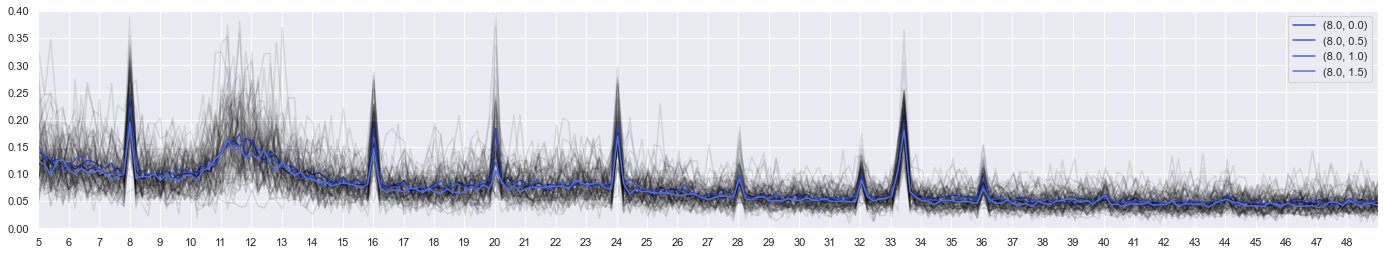

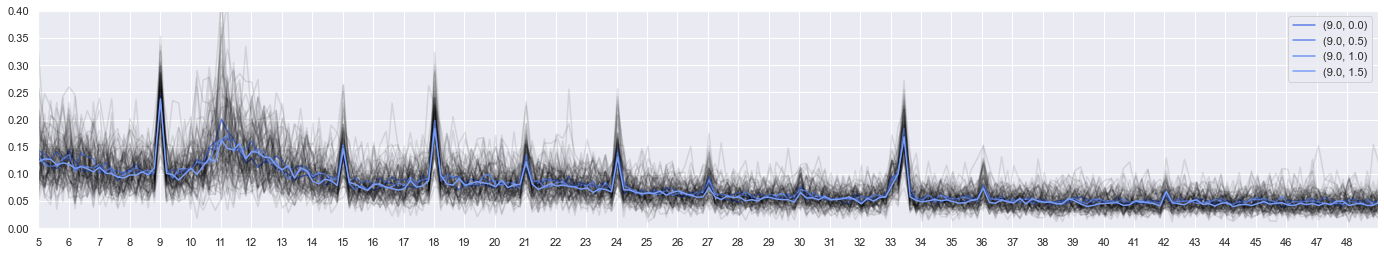

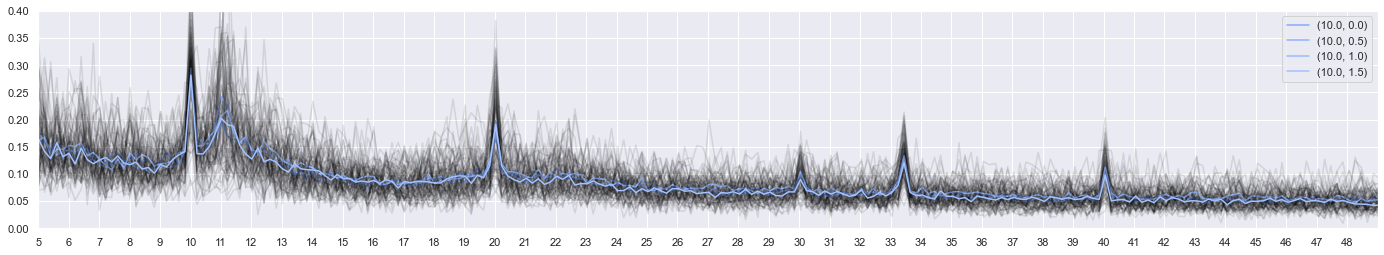

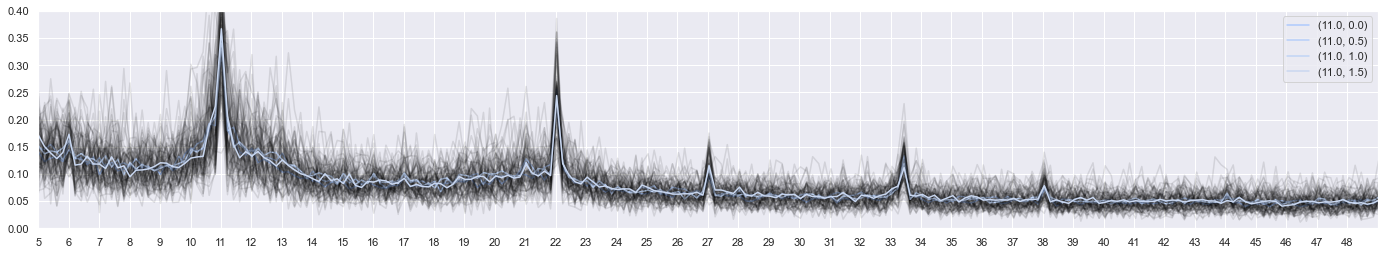

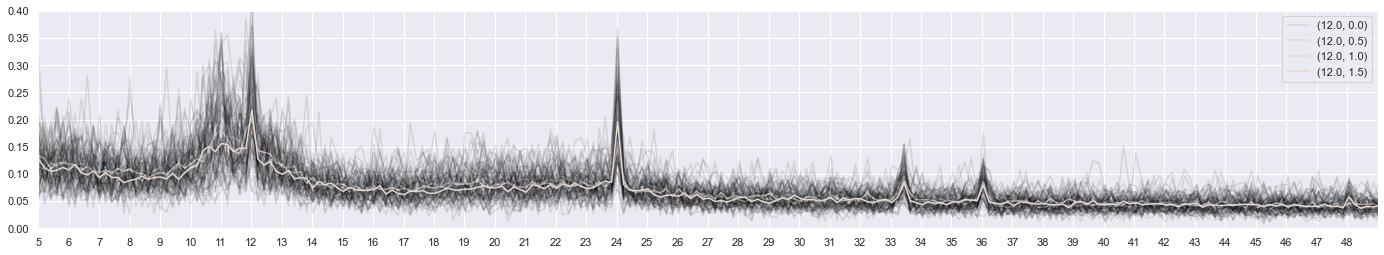

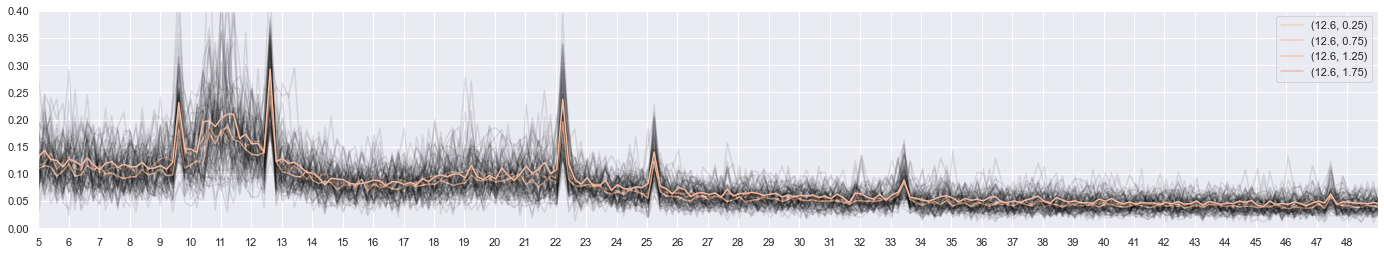

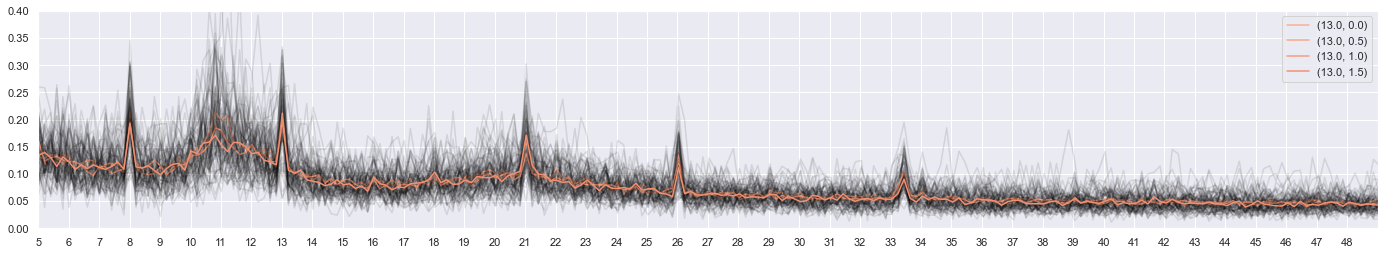

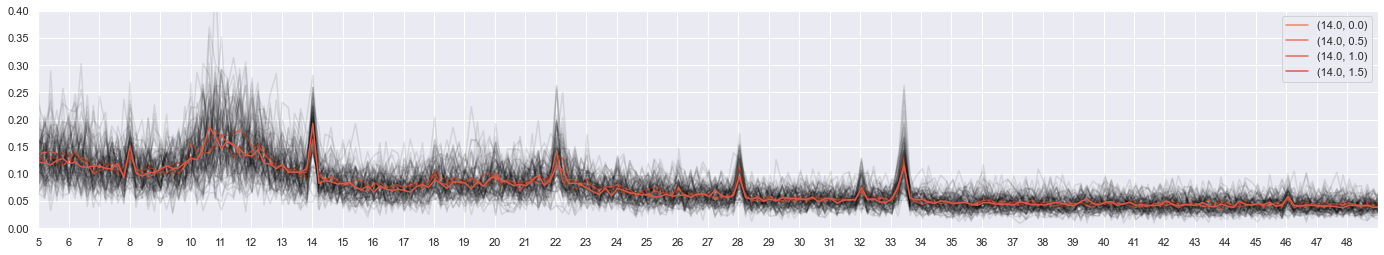

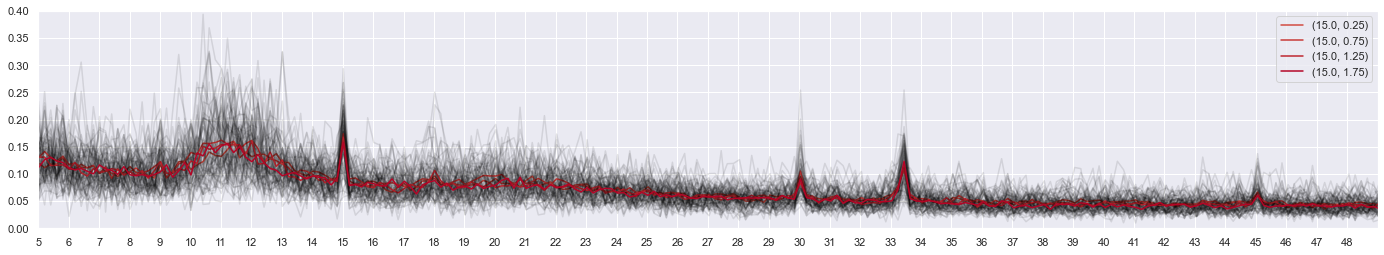

In [160]:
freqs = np.linspace(0.0, 300 / 2, 750)
psd = 2/750*np.abs(fft(eeg_variates)[:,:,:,:750])
# plt.figure(figsize=(24, 4))
# ax = plt.subplot()
# ax.set_xlim(5, 49)
# ax.set_ylim(0, 0.4)
colors=cm.coolwarm(np.linspace(0,1,36))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 4))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        ax.set_ylim(0, 0.4)
    for j in range(eeg_variates.shape[0]):
        # sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color=c, alpha = 0.1)
        sns.lineplot(x=freqs, y=psd[j,i,:,:].mean(axis=0), ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,:,:].mean(axis=0).mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)
# for i,c in enumerate(colors):
#     # sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)
#     sns.lineplot(x=freqs, y=psd[:,i,:,:].mean(axis=0).mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)
# plt.xticks(range(5,49));

#### Phase correction

In [216]:
def phase_shift(iptsignal, angle, dt):
    """Perform phase shift of arbitary angle
    Parameter
    =========
    iptsignal : numpy.array
        input signal
    angle : float
        angle to shift signal, in radian
    dt : float
        time step
    """
    # Resolve the signal's fourier spectrum
    spec = rfft(iptsignal)
    freq = rfftfreq(iptsignal.size, d=dt)

    # Perform phase shift in freqeuency domain
    spec *= np.exp(1.0j * (angle -0.5*np.pi )) # added '-0.5*np.pi'

    # Inverse FFT back to time domain
    phaseshift = irfft(spec, n=len(iptsignal)) /2 # added '/2'
    return phaseshift

In [217]:
# eeg_variates_avg = eeg_variates.mean(axis=2)
# eeg_variates_avg.shape

# weighted sum across the components
variates_corrs = np.zeros(eeg_variates.shape[:3])
for i in range(variates_corrs.shape[0]):
    for j in range(variates_corrs.shape[1]):
        total_corr = np.sum([np.corrcoef(eeg_variates[i,j,k],ref_variates[i,j,k])[0,1] for k in range(4)]) # sum of the correlations for each pair of components
        for k in range(variates_corrs.shape[2]):
            variates_corrs[i,j,k] = np.corrcoef(eeg_variates[i,j,k],ref_variates[i,j,k])[0,1]/total_corr
eeg_variates_sum = np.array([eeg_variates[...,i] * variates_corrs for i in range(eeg_variates.shape[-1])]).transpose(1,2,3,0).sum(axis=2) # weighted sum of the components

eeg_variates.shape, eeg_variates_sum.shape, max_corr_freqs.shape, variates_corrs.shape

((20, 36, 4, 1500), (20, 36, 1500), (20, 36), (20, 36, 4))

In [219]:
# phase-correct the eeg_variates_sum
fs = 300 # Sampling frequency 300hz
eeg_variates_shifted = np.zeros(eeg_variates_sum.shape)
orig_complex_spectrum = 2/750*fft(eeg)[:,:,0,:750] # Pz
variate_complex_spectrum = 2/750*fft(eeg_variates_sum)[:,:,:750]
for i in range(eeg_variates_shifted.shape[0]):
    for j in range(eeg_variates_shifted.shape[1]):
        max_corr_freq = max_corr_freqs[i,j]
        orig_phase = np.angle(orig_complex_spectrum[i,j][np.abs(freqs - max_corr_freq).argmin()])
        variate_phase = np.angle(variate_complex_spectrum[i,j][np.abs(freqs - max_corr_freq).argmin()])
        phase_delta = orig_phase - variate_phase
        eeg_variates_shifted[i,j,:] = phase_shift(eeg_variates_sum[i,j,:], phase_delta, 1/fs)
eeg_variates_shifted.shape

(20, 36, 1500)

In [207]:
classes = list(target_tab.keys())
freqs = np.linspace(0.0, 300 / 2, 1500//2)
complex_spectrum = 1/750*fft(eeg_variates_shifted)[:,:,:1500//2]
for i in range(9):
    pass

In [212]:
orig_complex_spectrum.shape

(20, 4, 750)